Train shape: torch.Size([50000, 3, 32, 32])
Test shape: torch.Size([10000, 3, 32, 32])
Epoch 0: Class Loss = 811.9033, Box Loss = 5.2233
Epoch 1: Class Loss = 657.9878, Box Loss = 4.1626
Epoch 2: Class Loss = 605.2435, Box Loss = 4.0259
Epoch 3: Class Loss = 578.7615, Box Loss = 3.9681
Epoch 4: Class Loss = 562.7117, Box Loss = 3.8890
Epoch 5: Class Loss = 551.1328, Box Loss = 3.8260
Epoch 6: Class Loss = 541.6532, Box Loss = 3.7802
Epoch 7: Class Loss = 533.0053, Box Loss = 3.7509
Epoch 8: Class Loss = 525.2023, Box Loss = 3.7315
Epoch 9: Class Loss = 517.9243, Box Loss = 3.7166
Epoch 10: Class Loss = 511.3487, Box Loss = 3.6925
Epoch 11: Class Loss = 505.6021, Box Loss = 3.7028
Epoch 12: Class Loss = 500.4369, Box Loss = 3.6869
Epoch 13: Class Loss = 495.6423, Box Loss = 3.6770
Epoch 14: Class Loss = 491.1843, Box Loss = 3.6767
Epoch 15: Class Loss = 487.1374, Box Loss = 3.6561
Epoch 16: Class Loss = 483.3506, Box Loss = 3.6505
Epoch 17: Class Loss = 479.7058, Box Loss = 3.6423
Epoch

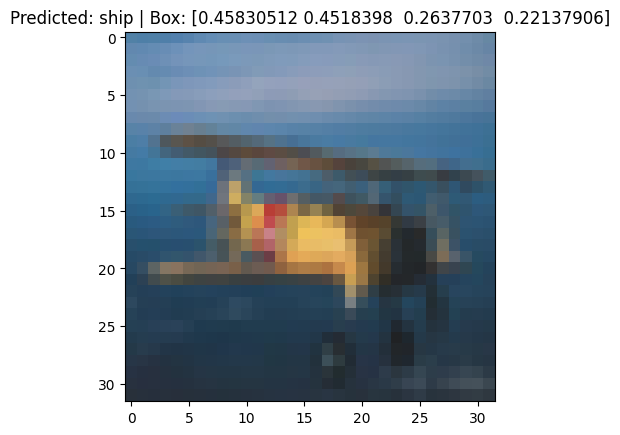

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from ndlinear import NdLinear
import os

# Load CIFAR-10 dataset 
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train = torch.tensor(X_train).permute(0, 3, 1, 2).float() / 255.0
y_train = torch.tensor(y_train).squeeze().long()
X_test = torch.tensor(X_test).permute(0, 3, 1, 2).float() / 255.0
y_test = torch.tensor(y_test).squeeze().long()

# Fake bounding boxes
def simulate_boxes(labels):
    boxes = []
    for label in labels:
        x = 0.1 + 0.05 * label + 0.05 * torch.rand(1)
        y = 0.1 + 0.05 * label + 0.05 * torch.rand(1)
        w = 0.2 + 0.1 * torch.rand(1)
        h = 0.2 + 0.1 * torch.rand(1)
        boxes.append(torch.tensor([x.item(), y.item(), w.item(), h.item()]))
    return torch.stack(boxes)

class NdCifarDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = NdLinear(input_dims=(3, 32, 32), hidden_size=(16, 16, 16))
        self.layer2 = NdLinear(input_dims=(16, 16, 16), hidden_size=(8, 8, 8))
        self.flatten = nn.Flatten()
        self.class_head = nn.Linear(8 * 8 * 8, 10)
        self.box_head = nn.Linear(8 * 8 * 8, 4)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = self.flatten(x)
        class_logits = self.class_head(x)
        box_out = self.box_head(x)
        return class_logits, box_out

model = NdCifarDetector()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn_class = nn.CrossEntropyLoss()
loss_fn_box = nn.MSELoss()

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Create directory
os.makedirs('saved_models', exist_ok=True)

# Training 
num_epochs = 50  
best_accuracy = 0

for epoch in range(num_epochs):
    model.train()
    total_class_loss, total_box_loss = 0, 0

    for i in range(0, len(X_train), 128):
        imgs = X_train[i:i+128].to(device)
        labels = y_train[i:i+128].to(device)
        boxes = simulate_boxes(labels).to(device)

        optimizer.zero_grad()
        class_logits, box_preds = model(imgs)
        loss_class = loss_fn_class(class_logits, labels)
        loss_box = loss_fn_box(box_preds, boxes)
        loss = loss_class + loss_box
        loss.backward()
        optimizer.step()

        total_class_loss += loss_class.item()
        total_box_loss += loss_box.item()

    print(f"Epoch {epoch}: Class Loss = {total_class_loss:.4f}, Box Loss = {total_box_loss:.4f}")

    # Save epochs every 10
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        torch.save(model.state_dict(), f'saved_models/model_epoch_{epoch}.pt')
        print(f"Model saved at epoch {epoch}")

    # Eval
    if epoch % 10 == 0 or epoch == num_epochs - 1:
        model.eval()
        all_preds, all_labels, all_boxes_true, all_boxes_pred = [], [], [], []

        with torch.no_grad():
            for i in range(0, len(X_test), 128):
                imgs = X_test[i:i+128].to(device)
                labels = y_test[i:i+128].to(device)
                boxes = simulate_boxes(labels).to(device)
                class_logits, box_preds = model(imgs)
                preds = class_logits.argmax(dim=1)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_boxes_true.extend(boxes.cpu().numpy())
                all_boxes_pred.extend(box_preds.cpu().numpy())

        acc = accuracy_score(all_labels, all_preds)
        bbox_mse = mean_squared_error(all_boxes_true, all_boxes_pred)

        print(f"\nEpoch {epoch} | Test Accuracy: {acc*100:.2f}% | Test BBox MSE: {bbox_mse:.4f}")

        # save best model
        if acc > best_accuracy:
            best_accuracy = acc
            torch.save(model.state_dict(), f'saved_models/best_model.pt')
            print(f"Best model saved with accuracy {acc*100:.2f}%")

